# Predicción de Demanda Energética de un Centro Educativo

En este Jupyter Notebook se realzan todos el ciclo de vida del preprocesamiento de los datos en crudo por tal de formar tres datasets diferentes: entrenamiento, validación y test. 

### Librerías

In [58]:
#Data Manipulation
import pandas as pd
import numpy as np
from datetime import timedelta

#Plots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Others
import holidays

#Parameters Dict
parameters = {
    "paths": {
        "meteo": "../data/Raw_Data/barcelona_meteo.csv",
        "demand": "../data/Raw_Data/CE_EO_Demanda.xlsx"
    }
}

### Datasets

In [59]:
#Electricity Demand Dataset
demand_df = pd.read_excel(parameters["paths"]["demand"], sheet_name="Demanda")
demand_df["Date"] = pd.to_datetime(demand_df["Date"])
demand_df = demand_df.rename(columns={'Demanda': 'Demand'})
demand_df.index = pd.DatetimeIndex(demand_df["Date"])
demand_df = demand_df.sort_index()
print(f"Demand Dataset, Nº of rows: {demand_df.shape[0]}")
display(demand_df.head(5))

#Meteorological Information Dataset
meteo_df = pd.read_csv(parameters["paths"]["meteo"])
meteo_df = meteo_df.rename(columns={'date': 'Date', "Temperatura": "Temperature"})
meteo_df["Date"] = pd.to_datetime(meteo_df["Date"], format='%m/%d/%y %H:%M')
print(f"Meteo Dataset Nº of rows: {meteo_df.shape[0]}")
display(meteo_df.head(5))

Demand Dataset, Nº of rows: 70080


,Date,Demand
Date,,
2018-01-01 00:15:00,2018-01-01 00:15:00,8
2018-01-01 00:30:00,2018-01-01 00:30:00,8
2018-01-01 00:45:00,2018-01-01 00:45:00,8
2018-01-01 01:00:00,2018-01-01 01:00:00,8
2018-01-01 01:15:00,2018-01-01 01:15:00,8


Meteo Dataset Nº of rows: 29472


,Date,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2017-01-01 00:00:00,8.422492,83,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 01:00:00,7.992492,81,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 02:00:00,7.642492,79,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 03:00:00,6.912492,79,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 04:00:00,6.352492,81,0.0,0.0,0.0,0.0,0.0


#### Missing Data and NaN Values

In [60]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='15min')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates

In [61]:
#Demand Dataset
print("Demand Dataset:")
checkNaNValues(demand_df)
missing_data = checkMissingData(demand_df, "Date")
print(" ")
#Meteo Dataset
#A resampling is performed in meteo dataset to obtain quarter-hour data
print("Meteo Dataset:")
checkNaNValues(meteo_df)
meteo_df.set_index('Date', inplace=True)
meteo_resampled_df = meteo_df.resample('15min').asfreq()
meteo_resampled_df.reset_index(inplace=True)
missing_meteo_data = checkMissingData(meteo_resampled_df, "Date")


Demand Dataset:
NaN Count per Column 0
Number of Missing Values: 0
 
Meteo Dataset:
NaN Count per Column 0
Number of Missing Values: 0


In [62]:
#Performs Interpolation between rows of a dataset, according to the specified columns and interpolation method
def interpolateData(df, columns, method):
    interpolated_df = df.copy()
    for col in columns:
        interpolated_df[col] = interpolated_df[col].interpolate(method=method)
    return interpolated_df

In [63]:
#When resampling the meteo dataset, we need to perform interpolation to fill the dataset
#In this case there are not any NaN Value to fill
columns2interpolate = meteo_resampled_df.columns.drop("Date")
df_meteo_interpolated = interpolateData(meteo_resampled_df, columns2interpolate, 'linear')
display(df_meteo_interpolated)

,Date,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2017-01-01 00:00:00,8.422492,83.0,0.0,0.000000,0.0,0.0,0.0
1,2017-01-01 00:15:00,8.314992,82.5,0.0,0.000000,0.0,0.0,0.0
2,2017-01-01 00:30:00,8.207492,82.0,0.0,0.000000,0.0,0.0,0.0
3,2017-01-01 00:45:00,8.099992,81.5,0.0,0.000000,0.0,0.0,0.0
4,2017-01-01 01:00:00,7.992492,81.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
117880,2020-05-12 22:00:00,16.682491,67.0,0.0,2.032979,0.0,0.0,0.0
117881,2020-05-12 22:15:00,16.672491,66.5,0.0,1.524734,0.0,0.0,0.0
117882,2020-05-12 22:30:00,16.662492,66.0,0.0,1.016489,0.0,0.0,0.0
117883,2020-05-12 22:45:00,16.652492,65.5,0.0,0.508245,0.0,0.0,0.0


### Datasets Merging

In [64]:
#The date range of the meteo dataset is adjusted to the demand dataset
min_date = demand_df["Date"].min()
max_date = demand_df["Date"].max()
new_meteo = df_meteo_interpolated[df_meteo_interpolated["Date"].between(min_date, max_date)]
print(f"Demand Dataset Length: {demand_df.shape[0]}, Meteo Dataset Length: {new_meteo.shape[0]}")
display(new_meteo.head(10))

Demand Dataset Length: 70080, Meteo Dataset Length: 70080


,Date,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
35041,2018-01-01 00:15:00,12.967492,60.50,0.0,0.0,0.0,0.0,0.0
35042,2018-01-01 00:30:00,12.972492,61.00,0.0,0.0,0.0,0.0,0.0
35043,2018-01-01 00:45:00,12.977492,61.50,0.0,0.0,0.0,0.0,0.0
35044,2018-01-01 01:00:00,12.982492,62.00,0.0,0.0,0.0,0.0,0.0
35045,2018-01-01 01:15:00,12.709992,61.50,0.0,0.0,0.0,0.0,0.0
35046,2018-01-01 01:30:00,12.437492,61.00,0.0,0.0,0.0,0.0,0.0
35047,2018-01-01 01:45:00,12.164992,60.50,0.0,0.0,0.0,0.0,0.0
35048,2018-01-01 02:00:00,11.892492,60.00,0.0,0.0,0.0,0.0,0.0
35049,2018-01-01 02:15:00,11.567492,59.75,0.0,0.0,0.0,0.0,0.0
35050,2018-01-01 02:30:00,11.242492,59.50,0.0,0.0,0.0,0.0,0.0


In [65]:
#Merge Demand Dataset and Meteo Dataset
demand_df = demand_df.reset_index(drop=True)
whole_df = pd.merge(demand_df, new_meteo, on='Date', how='inner')
display(whole_df.head(10))

,Date,Demand,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2018-01-01 00:15:00,8,12.967492,60.50,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 00:30:00,8,12.972492,61.00,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 00:45:00,8,12.977492,61.50,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 01:00:00,8,12.982492,62.00,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 01:15:00,8,12.709992,61.50,0.0,0.0,0.0,0.0,0.0
5,2018-01-01 01:30:00,8,12.437492,61.00,0.0,0.0,0.0,0.0,0.0
6,2018-01-01 01:45:00,12,12.164992,60.50,0.0,0.0,0.0,0.0,0.0
7,2018-01-01 02:00:00,8,11.892492,60.00,0.0,0.0,0.0,0.0,0.0
8,2018-01-01 02:15:00,8,11.567492,59.75,0.0,0.0,0.0,0.0,0.0
9,2018-01-01 02:30:00,8,11.242492,59.50,0.0,0.0,0.0,0.0,0.0


#### Outliers and Data Distribution

,Demand,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
count,70080.000000,70080.000000,70080.000000,70080.000000,70080.000000,70080.000000,70080.000000,70080.000000
mean,41.345091,16.932245,69.686658,0.060559,19.256275,193.724195,118.783871,74.940323
std,47.388407,6.350988,15.247045,0.398910,25.466023,260.813498,172.444323,93.146847
min,0.000000,-0.547508,10.000000,0.000000,0.000000,0.000000,-6.380158,0.000000
25%,8.000000,12.092492,59.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,16.617492,71.000000,0.000000,0.000000,23.362500,6.869148,11.099500
75%,72.000000,22.342491,81.500000,0.000000,51.223405,359.560000,209.834305,154.144927
max,236.000000,35.482494,100.000000,13.500000,60.000000,922.930000,627.331100,316.214970


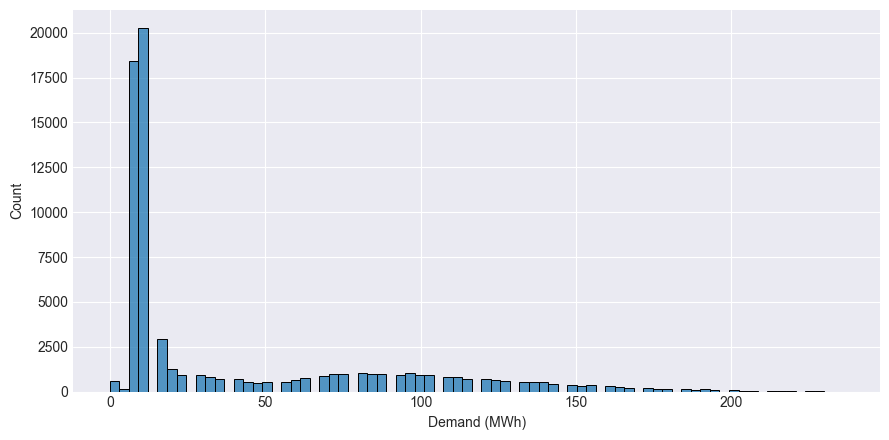

In [66]:
display(whole_df.drop(columns=["Date"]).describe())
fg = sns.displot(whole_df['Demand'], height=4.5, aspect= 2)
fg.set_axis_labels("Demand (MWh)", "Count")

Hay un pico de valores en la Demanda de 8 a 12 MWh, con un valor de 12 MWh en el percentil 50%. Por otro lado las variables de Temperatura y Humedad disponen de valores no 0s a lo largo de toda la serie temporal, no como el resto de varaibles que tienen el valor de 0 la mayoría del tiempo.

In [67]:
#Outliers
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}\n")


getNumberOfOutliersPerColumn(whole_df, whole_df.columns.drop("Date"))

For Demand Column, the Number of Outliers is 1224

For Temperature Column, the Number of Outliers is 0

For Relative_Humidity Column, the Number of Outliers is 452

For Precipitation_Total Column, the Number of Outliers is 5516

For Sunshine_Duration Column, the Number of Outliers is 0

For Shortwave_Radiation Column, the Number of Outliers is 119

For Direct_Shortwave_Radiation Column, the Number of Outliers is 3083

For Diffuse_Shortwave_Radiation Column, the Number of Outliers is 0



### Exogenous Variables

In [68]:
whole_df["Year"] = whole_df["Date"].dt.year
whole_df["Month"] = whole_df["Date"].dt.month
whole_df["Hour"] = whole_df["Date"].dt.hour
whole_df["DayOfWeek"] = whole_df["Date"].dt.day_of_week
whole_df["DayOfYear"] = whole_df["Date"].dt.day_of_year
whole_df["Day"] = whole_df["Date"].dt.day
whole_df["Minute"] = whole_df["Date"].dt.minute

In [69]:
#Generate a new column called Hour_sen and Hour_cos, wich is the hour 
#transformed by the sine and cosine function
def generateSinCosHour(df):
    df['Hour_sen'] = np.sin((df['Hour'] / 24) * np.pi * 2)  # = SIN((A1*PI())/24)
    df['Hour_cos'] = np.cos((df['Hour'] / 24) * np.pi * 2)
    return df

In [70]:
#Add Demand 7 days before Column
whole_df["Demand_7d"] = whole_df["Demand"].shift(7 * 96).fillna(0)

#Add isWeekend Column based in DayOfTheWeek Value
whole_df["isWeekend"] = whole_df["DayOfWeek"].isin([5, 6])

#Generate Sin and Cos Transformations
whole_df = generateSinCosHour(whole_df)

display(whole_df.head(5))

,Date,Demand,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation,Year,Month,Hour,DayOfWeek,DayOfYear,Day,Minute,Demand_7d,isWeekend,Hour_sen,Hour_cos
0,2018-01-01 00:15:00,8,12.967492,60.5,0.0,0.0,0.0,0.0,0.0,2018,1,0,0,1,1,15,0.0,False,0.000000,1.000000
1,2018-01-01 00:30:00,8,12.972492,61.0,0.0,0.0,0.0,0.0,0.0,2018,1,0,0,1,1,30,0.0,False,0.000000,1.000000
2,2018-01-01 00:45:00,8,12.977492,61.5,0.0,0.0,0.0,0.0,0.0,2018,1,0,0,1,1,45,0.0,False,0.000000,1.000000
3,2018-01-01 01:00:00,8,12.982492,62.0,0.0,0.0,0.0,0.0,0.0,2018,1,1,0,1,1,0,0.0,False,0.258819,0.965926
4,2018-01-01 01:15:00,8,12.709992,61.5,0.0,0.0,0.0,0.0,0.0,2018,1,1,0,1,1,15,0.0,False,0.258819,0.965926


In [71]:
#Add Demand 24 hours before Column
def getDayBeforeDemand(df, row):
    date = row["Date"]
    counter, demand_24h = 0, 0
    if row.isWeekend:
        while counter < 7:
            date -= timedelta(days=1)
            row_24h = df.loc[df["Date"] == date]
            if not row_24h.empty:
                row_24h = row_24h.iloc[[0]].squeeze()
                if row_24h["isWeekend"]:
                    demand_24h = row_24h["Demand"]
                    break
            counter += 1
    else:
        while counter < 7:
            date -= timedelta(days=1)
            row_24h = df.loc[df["Date"] == date]
            if not row_24h.empty:
                row_24h = row_24h.iloc[[0]].squeeze()
                if row_24h["isWeekend"]:
                    demand_24h = row_24h["Demand"]
                    break
            counter += 1
    return demand_24h

whole_df["Demand_24h"] = whole_df.apply(
    lambda row: getDayBeforeDemand(whole_df, row), axis=1
)

In [72]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

whole_df = generateHolidayVar(whole_df)
display(whole_df[["Date", "isHoliday"]].head(5))

,Date,isHoliday
0,2018-01-01 00:15:00,True
1,2018-01-01 00:30:00,True
2,2018-01-01 00:45:00,True
3,2018-01-01 01:00:00,True
4,2018-01-01 01:15:00,True


### <b>Plots</b>

#### Demand Distribution Plots

Text(0.5, 0.98, '')

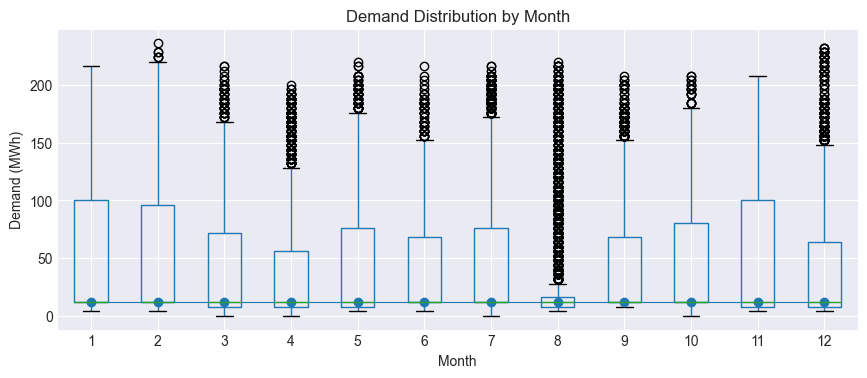

In [73]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Demand', by='Month', ax=ax)
whole_df.groupby('Month')['Demand'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand (MWh)')
ax.set_title("Demand Distribution by Month")
fig.suptitle('')

Text(0.5, 0.98, '')

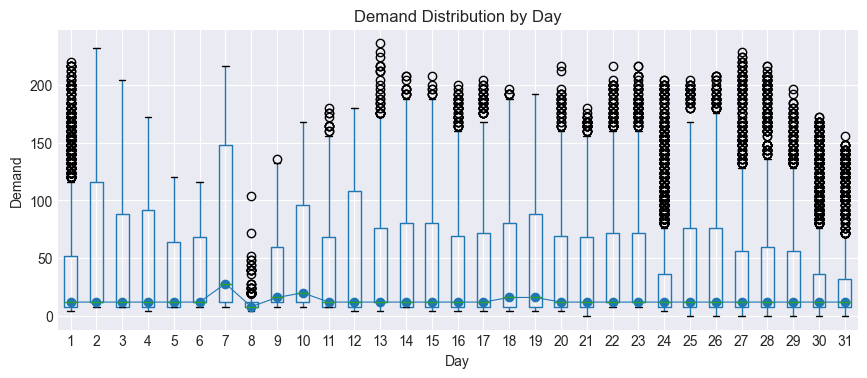

In [74]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Demand', by='Day', ax=ax)
whole_df.groupby('Day')['Demand'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Demand Distribution by Day")
fig.suptitle('')

Text(0.5, 0.98, '')

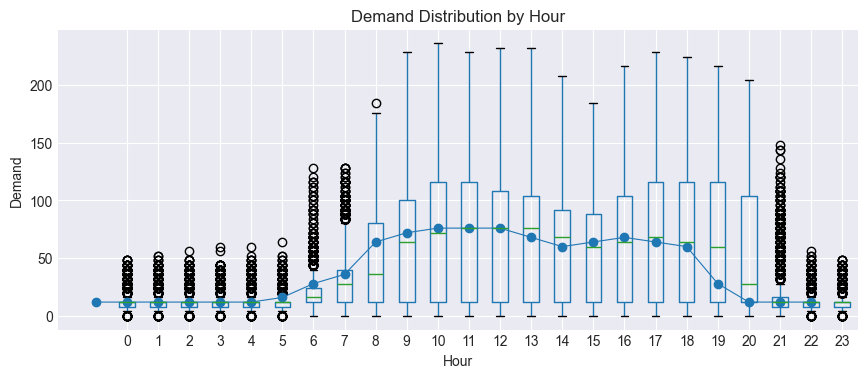

In [75]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Demand', by='Hour', ax=ax)
whole_df.groupby('Hour')['Demand'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Demand Distribution by Hour")
fig.suptitle('')

Text(0.5, 0.98, '')

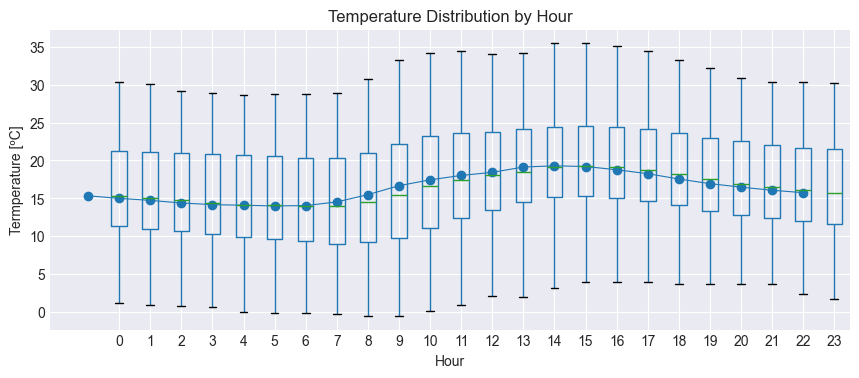

In [76]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Temperature', by='Hour', ax=ax)
whole_df.groupby('Hour')['Temperature'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperature [ºC]')
ax.set_title("Temperature Distribution by Hour")
fig.suptitle('')

Text(0.5, 0.98, '')

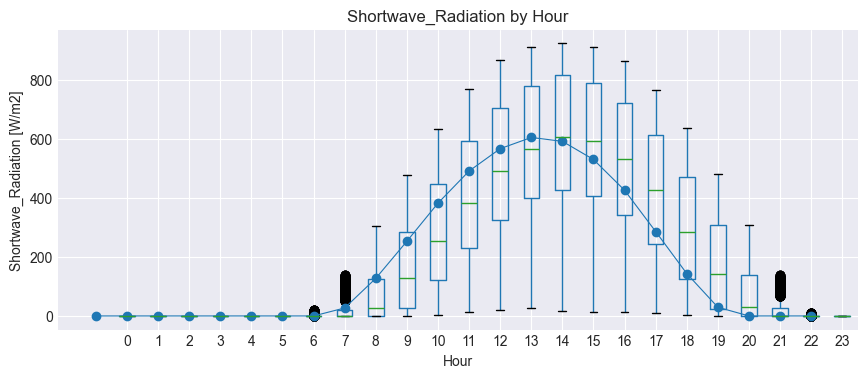

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Shortwave_Radiation', by='Hour', ax=ax)
whole_df.groupby('Hour')['Shortwave_Radiation'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Shortwave_Radiation [W/m2]')
ax.set_title("Shortwave_Radiation by Hour")
fig.suptitle('')

Text(0.5, 0.98, '')

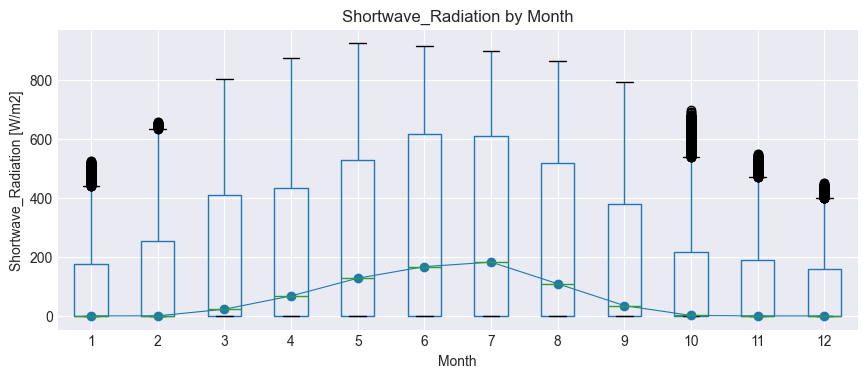

In [78]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Shortwave_Radiation', by='Month', ax=ax)
whole_df.groupby('Month')['Shortwave_Radiation'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Shortwave_Radiation [W/m2]')
ax.set_title("Shortwave_Radiation by Month")
fig.suptitle('')

Text(0.5, 0.98, '')

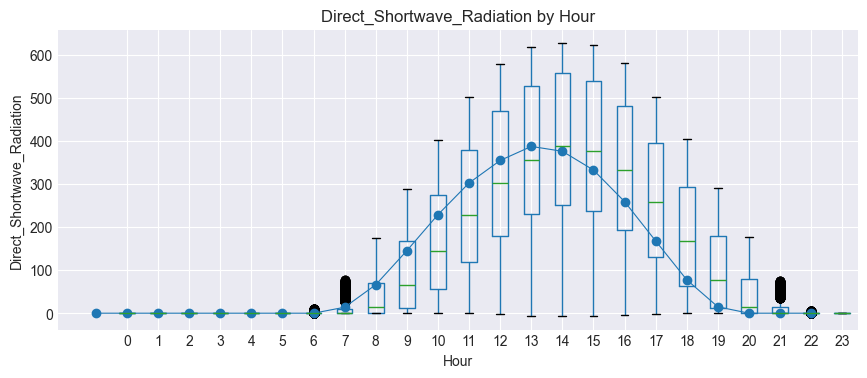

In [79]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Direct_Shortwave_Radiation', by='Hour', ax=ax)
whole_df.groupby('Hour')['Direct_Shortwave_Radiation'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Direct_Shortwave_Radiation')
ax.set_title("Direct_Shortwave_Radiation by Hour")
fig.suptitle('')

Text(0.5, 0.98, '')

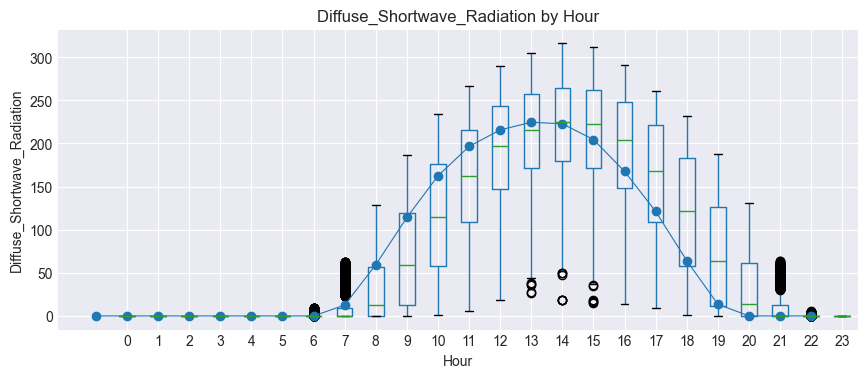

In [80]:
fig, ax = plt.subplots(figsize=(10, 4))
whole_df.boxplot(column='Diffuse_Shortwave_Radiation', by='Hour', ax=ax)
whole_df.groupby('Hour')['Diffuse_Shortwave_Radiation'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Diffuse_Shortwave_Radiation')
ax.set_title("Diffuse_Shortwave_Radiation by Hour")
fig.suptitle('')

#### Demand Historical Plots

In [81]:
# Weekly Demand Plot
whole_df.set_index('Date', inplace=True)
whole_df_1w = whole_df.resample('1W').mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Demand"], mode='lines'))
fig.update_layout(
    title = "Weekly Energy Demand",
    xaxis_title = "Date",
    yaxis_title = "Demand (MWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [82]:
start_date = whole_df.index.min()
end_date = start_date + timedelta(days=31)
df_month1 = whole_df.loc[(whole_df.index >= start_date) & (whole_df.index <= end_date)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_month1.index, y=df_month1["Demand"], mode='lines'))
fig.update_layout(
    title = "One Week Energy Demand",
    xaxis_title = "Date",
    yaxis_title = "Demand (MWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

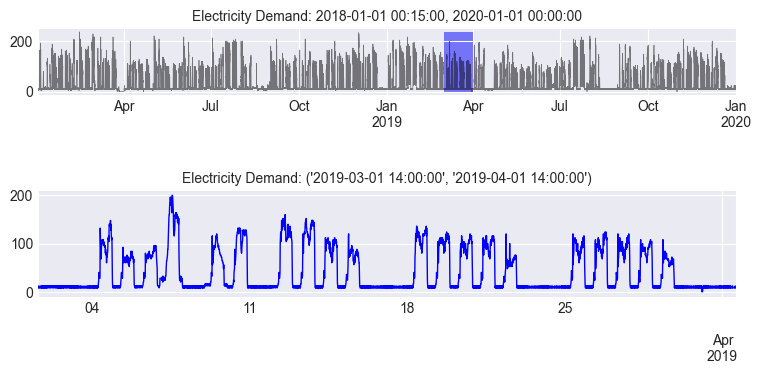

In [83]:
#Gráfico serie temporal con zoom
zoom = ('2019-03-01 14:00:00','2019-04-01 14:00:00')
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
whole_df.Demand.plot(ax=main_ax, c="black", alpha=0.5, linewidth=0.5)
min_y = min(whole_df.Demand)
max_y = max(whole_df.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
whole_df.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Electricity Demand: {whole_df.index.min()}, {whole_df.index.max()}', fontsize=10)
zoom_ax.set_title(f'Electricity Demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

#### AutoCorrelation Plots

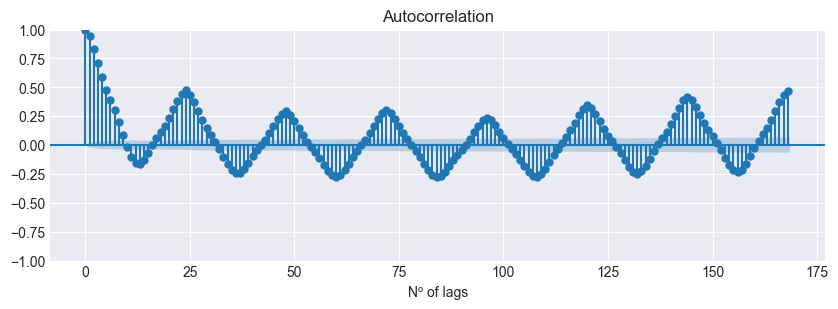

In [84]:
#Gráfico de autocorrelación 1
demand_df_1h = whole_df.resample('1h').mean()
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_acf(demand_df_1h.Demand, ax=ax, lags=24*7)
plt.show()

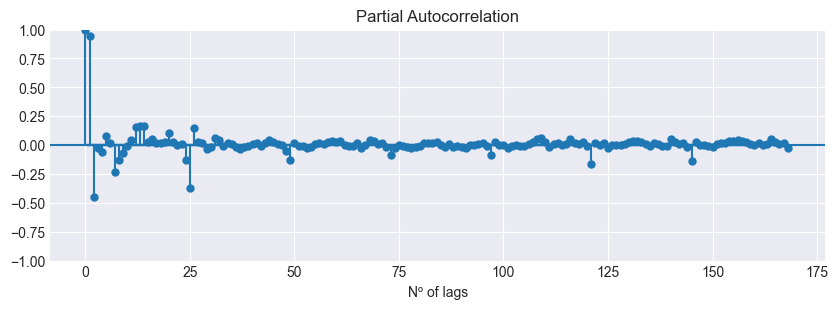

In [85]:
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(demand_df_1h.Demand, ax=ax, lags=24*7)
plt.show()

#### Demand per Day and Season


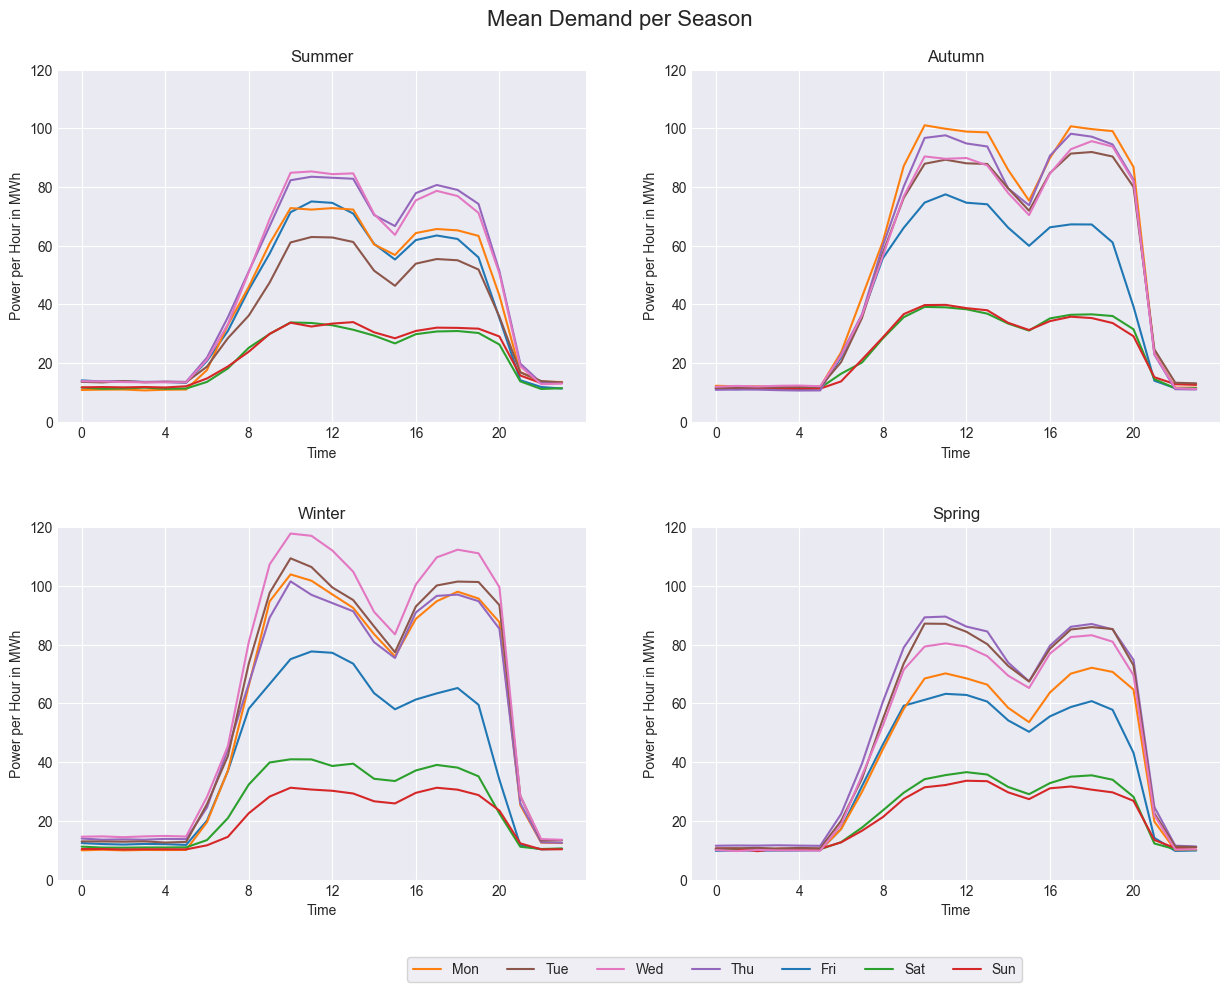

In [86]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
whole_df["Day"] = whole_df["DayOfWeek"].map(days_mapping)
whole_df["Season"] = whole_df["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Mean Demand per Season", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 120

#Season Summer
whole_df.loc[whole_df["Season"] == 2] \
    .groupby([whole_df.loc[whole_df["Season"] == 2]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
whole_df.loc[whole_df["Season"] == 3] \
    .groupby([whole_df.loc[whole_df["Season"] == 3]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
whole_df.loc[whole_df["Season"] == 0] \
    .groupby([whole_df.loc[whole_df["Season"] == 0]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
whole_df.loc[whole_df["Season"] == 1] \
    .groupby([whole_df.loc[whole_df["Season"] == 1]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='Time', ylabel='Power per Hour in MWh')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
whole_df = whole_df.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND


#### Correlation Matrix

Text(0.5, 1.0, 'Pearson Correlation Matrix')

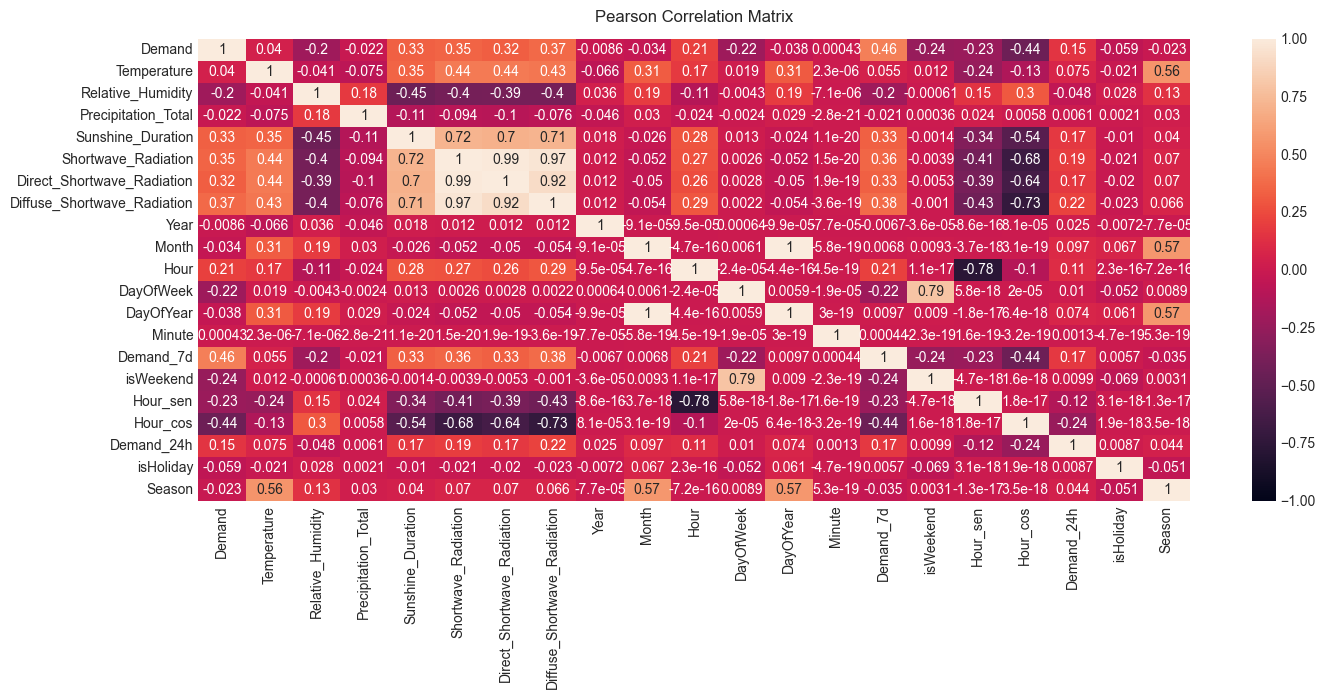

In [87]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,6))
corr_df = whole_df.copy()
#Drop Columns
heatmap = sns.heatmap(corr_df.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [88]:
whole_df = whole_df.reset_index()
display(whole_df.head(10))

,Date,Demand,Temperature,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation,Year,...,DayOfWeek,DayOfYear,Minute,Demand_7d,isWeekend,Hour_sen,Hour_cos,Demand_24h,isHoliday,Season
0,2018-01-01 00:15:00,8,12.967492,60.50,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,15,0.0,False,0.000000,1.000000,0,True,0
1,2018-01-01 00:30:00,8,12.972492,61.00,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,30,0.0,False,0.000000,1.000000,0,True,0
2,2018-01-01 00:45:00,8,12.977492,61.50,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,45,0.0,False,0.000000,1.000000,0,True,0
3,2018-01-01 01:00:00,8,12.982492,62.00,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,0,0.0,False,0.258819,0.965926,0,True,0
4,2018-01-01 01:15:00,8,12.709992,61.50,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,15,0.0,False,0.258819,0.965926,0,True,0
5,2018-01-01 01:30:00,8,12.437492,61.00,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,30,0.0,False,0.258819,0.965926,0,True,0
6,2018-01-01 01:45:00,12,12.164992,60.50,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,45,0.0,False,0.258819,0.965926,0,True,0
7,2018-01-01 02:00:00,8,11.892492,60.00,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,0,0.0,False,0.500000,0.866025,0,True,0
8,2018-01-01 02:15:00,8,11.567492,59.75,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,15,0.0,False,0.500000,0.866025,0,True,0
9,2018-01-01 02:30:00,8,11.242492,59.50,0.0,0.0,0.0,0.0,0.0,2018,...,0,1,30,0.0,False,0.500000,0.866025,0,True,0


#### Save Datasets

In [89]:
whole_df.to_csv("../data/Processed_Data/Demand_Dataset.csv", index=False)